# Package Installations and drive setup

In [1]:
!git clone https://github.com/Zafar-Lab/Margaret.git

Cloning into 'Margaret'...
remote: Enumerating objects: 1702, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 1702 (delta 259), reused 418 (delta 258), pack-reused 1281 (from 1)
Receiving objects: 100% (1702/1702), 9.48 MiB | 11.44 MiB/s, done.
Resolving deltas: 100% (1135/1135), done.


In [2]:
!pip install pandas==2.2.2

In [3]:
!pip install scanpy dca magic-impute palantir pygam louvain phate phenograph sh gprofiler-official

INFO: pip is looking at multiple versions of dca to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.0 MB/s eta 0:00:00

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/Margaret/margaret/

/content/Margaret/margaret


In [6]:
import numpy as np
import scanpy as sc
import torch
import pandas as pd
import scipy

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [7]:
import scanpy as sc

data = sc.read('/content/multifurcating_1_processed.h5ad')

# Trajectory Visualization

In [8]:
import numpy as np
from models.ti.connectivity import compute_directed_cluster_connectivity, compute_undirected_cluster_connectivity
from models.ti.graph import compute_trajectory_graph, compute_connectivity_graph
from utils.plot import plot_connectivity_graph, plot_trajectory_graph
from utils.util import get_start_cell_cluster_id

In [10]:
communities = data.obs['metric_clusters'].astype(int)
adj_conn = data.obsp['connectivities']
adj_dist = data.obsp['distances']
# start_cell_ids = adata.obs['palantir_pseudotime'].idxmin()
# start_cell_ids = [start_cell_ids] if isinstance(start_cell_ids, str) else list(start_cell_ids)
start_cell_ids = ['Cell726']
start_cluster_ids = get_start_cell_cluster_id(data, start_cell_ids, communities)
start_cluster_ids

{1}

In [11]:
un_connectivity, un_z_score = compute_undirected_cluster_connectivity(communities, adj_conn, z_threshold=2.5)

Runtime for compute_undirected_cluster_connectivity(): 0.9475116729736328


In [15]:
un_connectivity.to_csv("un_connectivity_1.csv")

In [12]:
print(f"Embeddings shape: {data.obsm['metric_embedding'].shape}")  # Should be (4880, 2)
print(f"Communities shape: {communities.shape}")  # Should be (4880,)


Embeddings shape: (920, 10)
Communities shape: (920,)


In [13]:
from umap import UMAP

# Reduce 10D embeddings to 2D
reducer = UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(data.obsm['metric_embedding'])


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Runtime for compute_connectivity_graph(): 0.014360666275024414


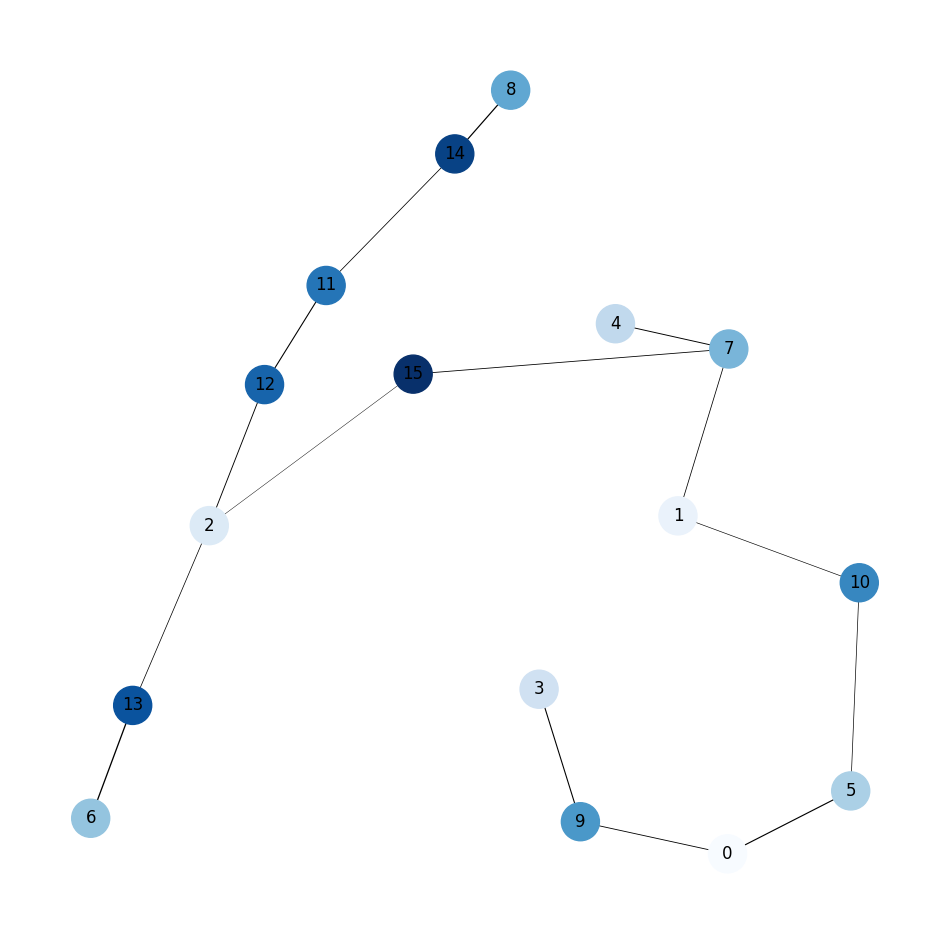

In [14]:
plot_connectivity_graph(embeddings_2d, communities, un_connectivity, mode='undirected', offset=0.2, cmap='Blues', node_size=750)

In [16]:
data.obsm["X_met_embedding"] = embeddings_2d

In [17]:
import matplotlib as mp
import networkx as nx


def plot_connectivity_graph_with_gene_expressions(
    ad,
    cluster_connectivities,
    gene,
    embedding_key="X_met_embedding",
    comm_key="metric_clusters",
    magic_key="X_magic",
    mode="undirected",
    cmap="YlGn",
    figsize=(16, 12),
    node_size=400,
    font_color="black",
    title=None,
    save_path=None,
    save_kwargs={},
    offset=0,
    **kwargs,
):
    try:
        X_embedded = ad.obsm[embedding_key]
    except KeyError:
        raise Exception(f"Key {embedding_key} not found in {ad}")

    try:
        communities = ad.obs[comm_key]
    except KeyError:
        raise Exception(f"Key {comm_key} not found in {ad}")

    try:
        X_imputed = pd.DataFrame(
            ad.obsm[magic_key], index=ad.obs_names, columns=ad.var_names
        )
    except KeyError:
        print("MAGIC imputed data not found. Using raw counts instead")
        X_imputed = ad.to_df()

    if gene not in ad.var_names:
        raise ValueError(f"Gene: {gene} was not found.")

    g, node_positions = compute_connectivity_graph(
        X_embedded, communities, cluster_connectivities, mode=mode
    )

    # Normalize and compute cluster wise mean expression of the gene
    X_gene = X_imputed[gene]
    X_gene = (X_gene - X_gene.min()) / (X_gene.max() - X_gene.min())
    gene_exprs = []
    for cluster_id in np.unique(communities):
        ids = communities == cluster_id
        mean_gene_expr = X_gene.loc[ids].mean()
        gene_exprs.append(mean_gene_expr)

    # Draw the graph
    plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    edge_weights = [offset + w for _, _, w in g.edges.data("weight")]
    nx.draw_networkx(
        g,
        pos=node_positions,
        cmap=cmap,
        node_color=gene_exprs,
        font_color=font_color,
        node_size=node_size,
        width=edge_weights,
        **kwargs,
    )
    # Setup color bar
    vmin = np.min(gene_exprs)
    vmax = np.max(gene_exprs)
    normalize = mp.colors.Normalize(vmin=vmin, vmax=vmax)
    cax, _ = mp.colorbar.make_axes(plt.gca(), aspect=20, shrink=0.6, anchor=(-0.3, 0.5))
    mp.colorbar.ColorbarBase(cax, norm=normalize, cmap=plt.get_cmap(cmap))

    if save_path is not None:
        plt.savefig(save_path, **save_kwargs)
    plt.show()

In [22]:
connectivity, z_score = compute_directed_cluster_connectivity(communities, adj_conn, threshold=2)

Runtime for compute_directed_cluster_connectivity(): 0.2584261894226074


# Pseudotime Computation

In [23]:
import networkx as nx

from sklearn.neighbors import NearestNeighbors
from models.ti.pseudotime import compute_pseudotime
from models.ti.pseudotime_v2 import compute_pseudotime
from models.ti.graph import compute_trajectory_graph_v2
from utils.plot import plot_trajectory_graph_v2
from utils.plot import plot_pseudotime

In [24]:
X = data.obsm['metric_embedding']

n_neighbors = 30
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
adj_dist = nbrs.kneighbors_graph(X, mode="distance")
adj_conn = nbrs.kneighbors_graph(X)

In [25]:
# v2 pseudotime
G_undirected, node_positions = compute_connectivity_graph(data.obsm['X_met_embedding'], data.obs['metric_clusters'], un_connectivity)
adj_cluster = nx.to_pandas_adjacency(G_undirected)
pseudotime = compute_pseudotime(data, start_cell_ids, adj_dist, adj_cluster)

Runtime for compute_connectivity_graph(): 0.008850336074829102
Runtime for compute_pseudotime(): 0.14566731452941895


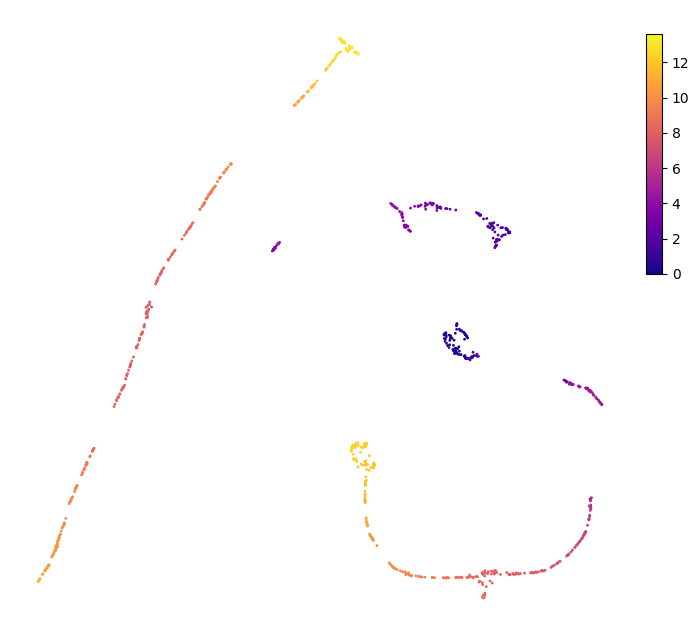

In [26]:
plot_pseudotime(
    data,
    embedding_key="X_met_embedding",
    pseudotime_key="metric_pseudotime_v2",
    s=1,
    cmap='plasma',
    figsize=(8, 8),
    cb_axes_pos=[0.92, 0.55, 0.02, 0.3],
    save_path='/content/pseudotime_v2.png',
    save_kwargs={
        'dpi': 300,
        'bbox_inches': 'tight',
        'transparent': True
    }
)

Runtime for compute_trajectory_graph_v2(): 0.02054429054260254
Runtime for compute_trajectory_graph_v2(): 0.01910400390625


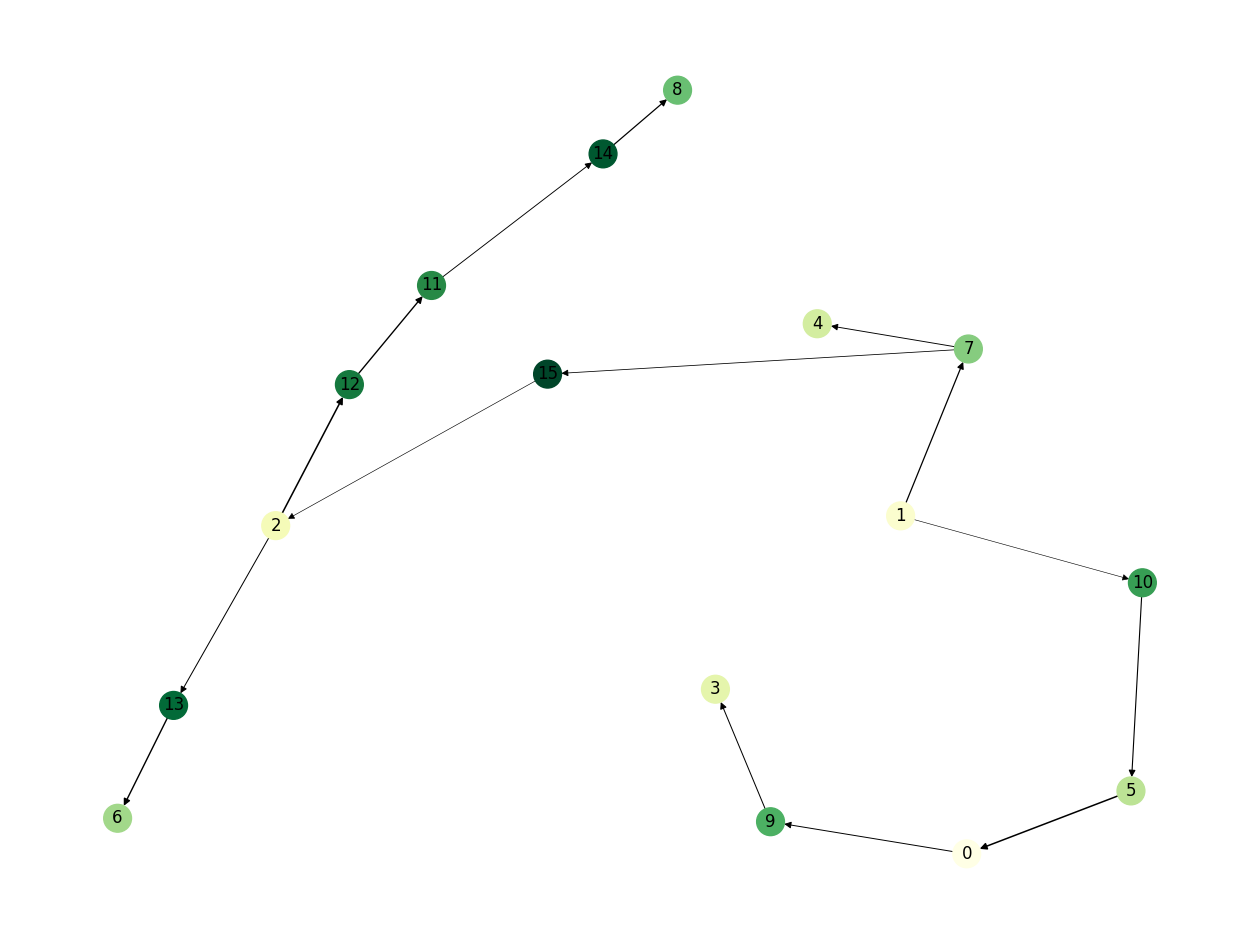

In [27]:
# Compute directed graph v2
G_directed_v2 = compute_trajectory_graph_v2(pseudotime, adj_cluster, data.obs['metric_clusters'], connectivity)
plot_trajectory_graph_v2(pseudotime, adj_cluster, data.obs['metric_clusters'], connectivity, node_positions, offset=0.2)

# Plotting and Visualization

In [30]:
%matplotlib inline

In [31]:
from utils.plot import generate_plot_embeddings, plot_gene_expression, plot_embeddings, plot_clusters
import matplotlib.pyplot as plt

## Embedding Visualization

In [32]:
X_embedded = generate_plot_embeddings(data.obsm['metric_embedding'], method='tsne', perplexity=150, random_state=0)
data.obsm['X_met_embedding'] = X_embedded

Runtime for generate_plot_embeddings(): 12.849348068237305


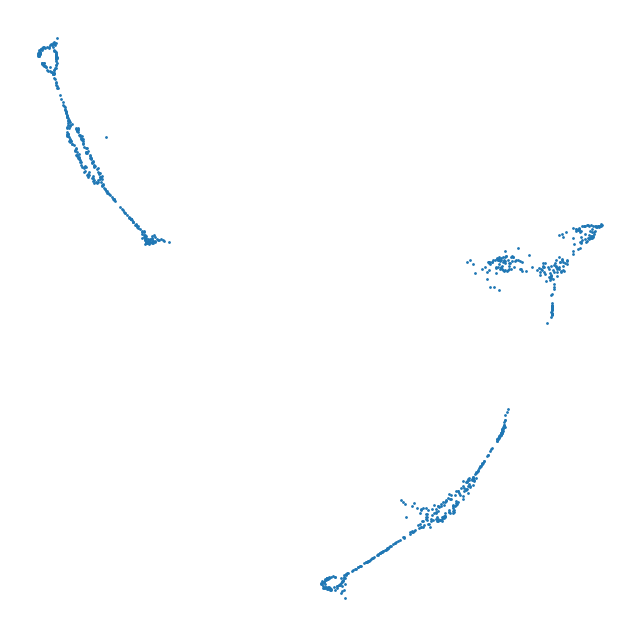

In [33]:
plot_embeddings(data.obsm['X_met_embedding'], s=1, figsize=(8, 8))